In [1]:
!pip -q install ultralytics pyyaml opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.6 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import zipfile
import os
from ultralytics import YOLO
import os, glob, random
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import yaml
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
zip= Path("/content/TXL-PBC.zip")
out= Path("/content")

with zipfile.ZipFile(zip, "r") as z:
    z.extractall(out)


In [6]:
def count_files(caminho):
  ficheiros = os.listdir(caminho)
  return len(ficheiros)

In [7]:
DS_path= Path("/content/TXL-PBC")
img_train = DS_path / "images" / "train"
img_val   = DS_path / "images" / "val"
img_test  = DS_path / "images" / "test"

lbl_train = DS_path / "labels" / "train"
lbl_val   = DS_path / "labels" / "val"
lbl_test  = DS_path / "labels" / "test"

pastas={
    'img_train': img_train,
    'img_val': img_val,
    'img_test': img_test,
    'lbl_train': lbl_train,
    'lbl_val': lbl_val,
    'lbl_test': lbl_test
}
counting={}
for nome, caminho in pastas.items():
  contagem= count_files(caminho)
  counting[nome]=contagem
  print(f"{nome} --- {contagem}")

img_train --- 882
img_val --- 252
img_test --- 126
lbl_train --- 882
lbl_val --- 252
lbl_test --- 126


In [ ]:
counting

{'img_train': 882,
 'img_val': 252,
 'img_test': 126,
 'lbl_train': 882,
 'lbl_val': 252,
 'lbl_test': 126}

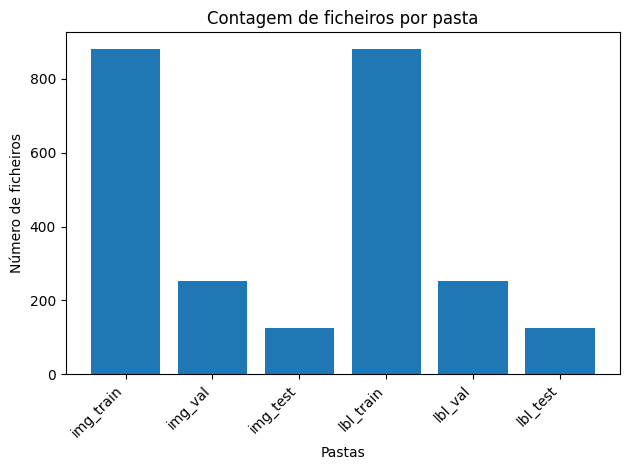

In [ ]:
plt.bar(counting.keys(), counting.values())
plt.xlabel('Pastas')
plt.ylabel('Número de ficheiros')
plt.title('Contagem de ficheiros por pasta')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def find_image(image_dir: Path, stem: str):
  i = image_dir / f"{stem}.png"
  if i.exists():
      return i
  return None

def parse_label_file(label_file: Path):
    """Lê ficheiro YOLO e retorna lista de boxes."""
    rows = []
    lines = label_file.read_text().strip().splitlines()

    for ln in lines:
        parts = ln.split()
        if len(parts) >= 5:
            cls = int(float(parts[0]))
            x, y, w, h = map(float, parts[1:5])
            rows.append((cls, x, y, w, h))
    return rows


split_map = {
    "train": (lbl_train, img_train),
    "val": (lbl_val, img_val),
    "test": (lbl_test, img_test),
}

records = []
empty_label_files = []
missing_images = []

# Processa cada split
for split, (lbl_dir, img_dir) in split_map.items():
    for lf in sorted(Path(lbl_dir).glob("*.txt")):
        stem = lf.stem
        boxes = parse_label_file(lf)

        if not boxes:
            empty_label_files.append((split, stem))
            continue

        # Tenta ler dimensões da imagem
        img_path = find_image(Path(img_dir), stem)
        W = H = None
        if img_path:
            im = cv2.imread(str(img_path))
            if im is not None:
                H, W = im.shape[:2]
        else:
            missing_images.append((split, stem))

        # Cria registo para cada box
        for cls, x, y, w, h in boxes:
            rec = {
                "split": split, "image": stem, "class": cls,
                "x": x, "y": y, "w": w, "h": h,
                "area_rel": w * h,
                "aspect": w / h if h > 0 else None
            }
            if W and H:
                rec.update({
                    "W": W, "H": H,
                    "w_px": w * W, "h_px": h * H,
                    "area_px": w * W * h * H
                })
            records.append(rec)

df = pd.DataFrame(records)

In [ ]:
df

,split,image,class,x,y,w,h,area_rel,aspect,W,H,w_px,h_px,area_px
0,train,002c1600f18359869647c3f9ec77f637,1,0.225217,0.182609,0.217391,0.229565,0.049905,0.946969,575,575,124.999825,131.999875,16499.961275
1,train,002c1600f18359869647c3f9ec77f637,1,0.903478,0.753043,0.189565,0.243478,0.046155,0.778571,575,575,108.999875,139.999850,15259.966150
2,train,002c1600f18359869647c3f9ec77f637,1,0.121739,0.898261,0.233043,0.200000,0.046609,1.165215,575,575,133.999725,115.000000,15409.968375
3,train,002c1600f18359869647c3f9ec77f637,1,0.093043,0.340870,0.186087,0.215652,0.040130,0.862904,575,575,107.000025,123.999900,13267.992400
4,train,002c1600f18359869647c3f9ec77f637,1,0.881739,0.945217,0.233043,0.106087,0.024723,2.196716,575,575,133.999725,61.000025,8173.986575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,test,fe2b9262a72c51ef802ba156aa5c3bd0,1,0.615234,0.353516,0.175781,0.246094,0.043259,0.714284,256,256,44.999936,63.000064,2834.998848
18139,test,fe2b9262a72c51ef802ba156aa5c3bd0,1,0.169922,0.529297,0.222656,0.253906,0.056534,0.876923,256,256,56.999936,64.999936,3704.992192
18140,test,fe2b9262a72c51ef802ba156aa5c3bd0,0,0.667969,0.763672,0.382812,0.371094,0.142059,1.031577,256,256,97.999872,95.000064,9309.994112
18141,test,fe2b9262a72c51ef802ba156aa5c3bd0,1,0.361328,0.908203,0.230469,0.167969,0.038712,1.372092,256,256,59.000064,43.000064,2537.006528


In [ ]:
print("Total de boxes:", len(df))
print("Boxes por split:", df.groupby("split").size().to_dict())
print("Boxes por classe:", df.groupby("class").size().to_dict())
print("Label files vazios:", pd.DataFrame(empty_label_files, columns=["split","image"]).groupby("split").size().to_dict())
print("Imagens em falta para labels:", pd.DataFrame(missing_images, columns=["split","image"]).groupby("split").size().to_dict())

Total de boxes: 18143
Boxes por split: {'test': 1881, 'train': 12510, 'val': 3752}
Boxes por classe: {0: 1298, 1: 16302, 2: 543}
Label files vazios: {}
Imagens em falta para labels: {}


In [ ]:
# Sanity check: YOLO tem de estar em [0,1]
bad = df[(df[["x","y","w","h"]] < 0).any(axis=1) | (df[["x","y","w","h"]] > 1).any(axis=1)]
print("Boxes fora de [0,1]:", len(bad))


Boxes fora de [0,1]: 0


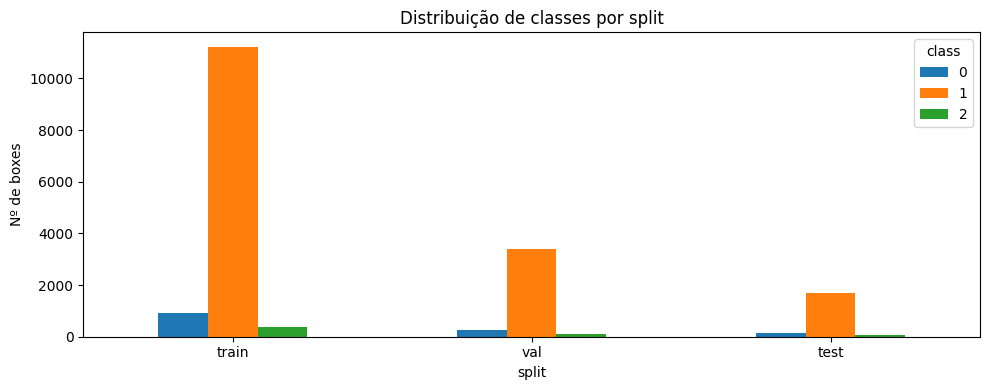

In [ ]:
counts = df.groupby(["split","class"]).size().unstack(fill_value=0).reindex(["train","val","test"])
counts.plot(kind="bar", figsize=(10,4))
plt.ylabel("Nº de boxes")
plt.title("Distribuição de classes por split")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3837656520.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=splits, showfliers=False)


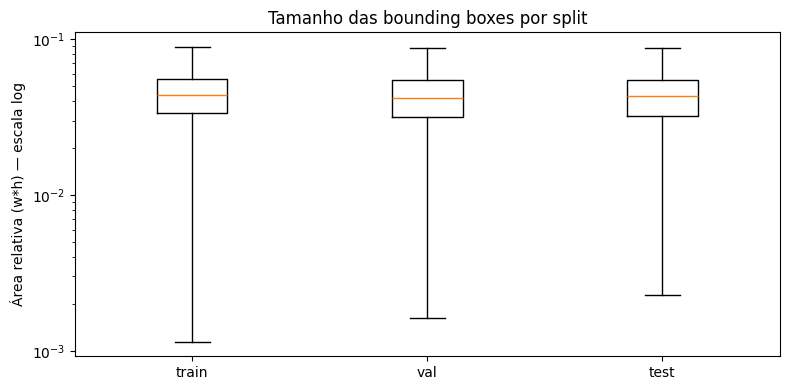

In [ ]:
# 5.2 Área relativa por split (log)
splits = ["train","val","test"]
data = [df[df["split"]==s]["area_rel"].values for s in splits]
plt.figure(figsize=(8,4))
plt.boxplot(data, labels=splits, showfliers=False)
plt.yscale("log")
plt.ylabel("Área relativa (w*h) — escala log")
plt.title("Tamanho das bounding boxes por split")
plt.tight_layout()
plt.show()

/tmp/ipython-input-188450658.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=classes, showfliers=False)


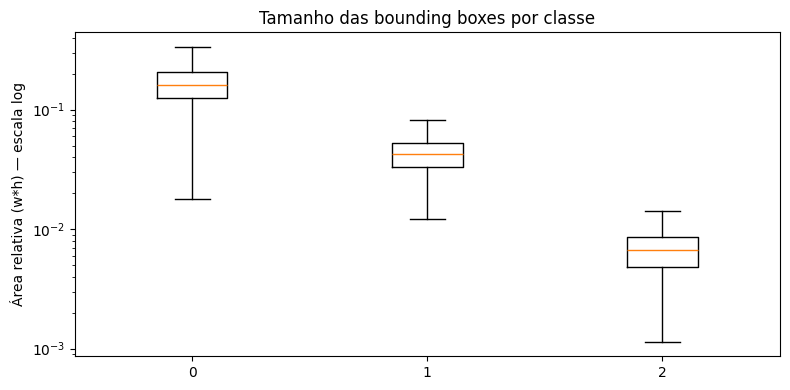

In [ ]:
# 5.3 Área relativa por classe (log)
classes = sorted(df["class"].unique())
data = [df[df["class"]==c]["area_rel"].values for c in classes]
plt.figure(figsize=(8,4))
plt.boxplot(data, labels=classes, showfliers=False)
plt.yscale("log")
plt.ylabel("Área relativa (w*h) — escala log")
plt.title("Tamanho das bounding boxes por classe")
plt.tight_layout()
plt.show()

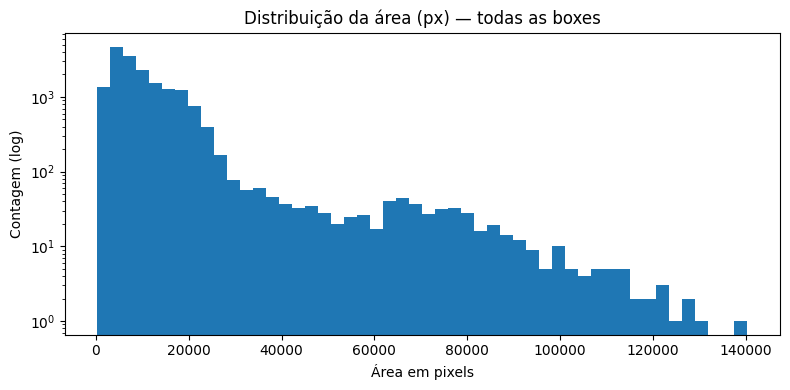

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df["area_px"].dropna().values, bins=50)
plt.yscale("log")
plt.xlabel("Área em pixels")
plt.ylabel("Contagem (log)")
plt.title("Distribuição da área (px) — todas as boxes")
plt.tight_layout()
plt.show()

In [8]:
model = YOLO("yolov8n.pt")


print("A iniciar treino com YOLOv8 e batch=100...")
results = model.train(
    data=str(DS_path / "data.yaml"),
    epochs=100,
    imgsz=320,
    batch=100, 
    workers=0,
    optimizer="AdamW",
    lr0=0.001,
    cache=True,
    project="yolo_training",
    name="yolov8_batch100"
)

print("Treino concluído!")
print(f"Resultados guardados em: {results.save_dir}")

🚀 A iniciar treino com YOLOv8 e batch=100...
Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=100, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/TXL-PBC/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8_batch100, nbs=64, nms=False, opset=None, optimize=False, optimize

In [12]:
model = YOLO("yolov8n.pt")

results = model.train(
    data=str(DS_path / "data.yaml"),
    epochs=100,
    imgsz=320,
    batch=16,
    workers=0,
    optimizer="SGD",  
    lr0=0.001,
    momentum=0.937,  
    weight_decay=0.0005,  
    cache=True,
    project="yolo_training",
    name="yolov8_sgd"
)

print("Treino concluído!")
print(f"Resultados guardados em: {results.save_dir}")

A iniciar treino com YOLOv8 e optimizer SGD...
Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/TXL-PBC/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8_sgd, nbs=64, nms=False, opset=None, optimize=False, optimizer=SG

In [ ]:
!ls -la /content/runs/detect/train


total 1004
drwxr-xr-x 3 root root   4096 Jan 31 16:48 .
drwxr-xr-x 4 root root   4096 Jan 31 16:49 ..
-rw-r--r-- 1 root root   1575 Jan 31 16:47 args.yaml
-rw-r--r-- 1 root root 119178 Jan 31 16:48 labels.jpg
-rw-r--r-- 1 root root 284647 Jan 31 16:48 train_batch0.jpg
-rw-r--r-- 1 root root 287644 Jan 31 16:48 train_batch1.jpg
-rw-r--r-- 1 root root 310328 Jan 31 16:48 train_batch2.jpg
drwxr-xr-x 2 root root   4096 Jan 31 16:47 weights


In [13]:
from google.colab import files
import shutil

shutil.make_archive('meu_arquivo', 'zip', '/content/runs/detect/yolo_training/yolov8_sgd')
files.download('meu_arquivo.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>